In [14]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import random
import os

In [15]:
# Reading data files from my computer

def get_data():
    directory_pwd = '/Users/charbel/Desktop/GitHub/COVID-Hackathon/'
    directory = os.fsencode(directory_pwd)
    data = []
    labels = []
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".csv"): 
            full_path = directory_pwd + filename
            df = pd.read_csv(full_path)
            df = df[df.Province_State != "Recovered"]
            df = df.drop(["Lat", "Long_", "Last_Update", "Province_State", "Country_Region", "UID", "ISO3", "FIPS", "Deaths", "Active"], 1)
            df = df.fillna(df.median())
            labels.append(df['Confirmed'].to_numpy())
            df = df.drop(['Confirmed'], 1)
            data.append(df.to_numpy())
    return data, labels

data, labels = get_data()
data = np.stack(data)
data = data/np.max(data) - np.ones(data.shape) / 2
print("data", data.shape)
labels = np.stack(labels)
print("labels", labels.shape)
labels = labels/np.max(labels) - np.ones(labels.shape) / 2
# (# of days, #of states/province, #of features)
#print(data)


data (104, 58, 7)
labels (104, 58)


In [16]:
class RNN(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.rnn = nn.LSTM(input_size=58*7,
                          hidden_size=hidden_size,
                          batch_first=True)
        self.proj = nn.Linear(in_features=hidden_size,
                              out_features=58)
    
    def forward(self, inp):
        X = inp.reshape([-1,58*7]).unsqueeze(dim=0)
        out, last_hidden = self.rnn(X)
        out_seq = self.proj(out)
        return out_seq.squeeze()

In [17]:
rnn = RNN(200)
y = rnn(torch.Tensor(data))
y.shape

torch.Size([104, 58])

In [18]:
train_data, valid_data = data[:83, :], data[83:, :]
print("train_data: ", train_data.shape)
print("valid_data: ", valid_data.shape)
train_labels, valid_labels = labels[:83, :], labels[83:, :]
print("train_labels: ", train_labels.shape)
print("valid_labels ", valid_labels.shape)

train_data:  (83, 58, 7)
valid_data:  (21, 58, 7)
train_labels:  (83, 58)
valid_labels  (21, 58)


In [19]:
def get_batches_and_labels(data, labels, batch_size=10):
    batches = []
    b_labels = []
    for i in range(0, data.shape[0], batch_size):
        batches.append(torch.Tensor(data[i:i+batch_size, :, :]))
        b_labels.append(torch.Tensor(labels[i:i+batch_size, :]))
    return batches, b_labels

b, l = get_batches_and_labels(train_data, train_labels)
for i in range(len(b)):
    print(b[i].shape, "--------", l[i].shape)

torch.Size([10, 58, 7]) -------- torch.Size([10, 58])
torch.Size([10, 58, 7]) -------- torch.Size([10, 58])
torch.Size([10, 58, 7]) -------- torch.Size([10, 58])
torch.Size([10, 58, 7]) -------- torch.Size([10, 58])
torch.Size([10, 58, 7]) -------- torch.Size([10, 58])
torch.Size([10, 58, 7]) -------- torch.Size([10, 58])
torch.Size([10, 58, 7]) -------- torch.Size([10, 58])
torch.Size([10, 58, 7]) -------- torch.Size([10, 58])
torch.Size([3, 58, 7]) -------- torch.Size([3, 58])


In [20]:
def get_accuracy(model, data, labels):
    correct = 0
    out = model(torch.Tensor(data))
    difference = out - torch.Tensor(labels)
    summed_out = torch.sum(difference, axis=1)
    for diff in summed_out:
        if diff <= 0.0004:
            correct += 1
    return correct/summed_out.shape[0]
get_accuracy(rnn, train_data, train_labels)

0.0

In [21]:
# Write your code here
def train_model(model, train_data, valid_data, train_labels, valid_labels, batch_size=10, weight_decay=0.0,
          learning_rate=0.001, num_epochs=40, checkpoint_path=None):
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay)
    iters, losses, train_acc, val_acc = [], [], [], []   
    n = 0
    
    for epoch in range(num_epochs):
        
        batches, labels = get_batches_and_labels(train_data, train_labels, batch_size=batch_size)
        
        for i in range(len(batches)):
            model.train()
            #out = torch.sum(model(batches[i]), axis=1)
            #print("here")
            out = model(batches[i])
            #print(out.shape)
            #target = torch.sum(labels[i], axis=1)
            target = labels[i]
            #print(target.shape)
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            n += 1
            
        # save the current training information
        loss = float(loss)/batch_size
        tacc = get_accuracy(model, train_data, train_labels)
        vacc = get_accuracy(model, valid_data, valid_labels)
        print("Epoch %d; Loss %f; Train Acc %.3f; Val Acc %.3f;" % (epoch+1, loss, tacc, vacc))
            
        iters.append(n)
        losses.append(loss)
        train_acc.append(tacc)
        val_acc.append(vacc)
        
        if (checkpoint_path is not None) and n > 0:
            torch.save(model.state_dict(), checkpoint_path.format(epoch))
        
    # plotting
    plt.title("Learning Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()
        
    plt.title("Learning Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()
  

Epoch 1; Loss 0.007193; Train Acc 0.000; Val Acc 0.000;
Epoch 2; Loss 0.002033; Train Acc 0.988; Val Acc 0.952;
Epoch 3; Loss 0.000734; Train Acc 0.181; Val Acc 0.190;
Epoch 4; Loss 0.000474; Train Acc 0.602; Val Acc 0.667;
Epoch 5; Loss 0.000421; Train Acc 0.554; Val Acc 0.619;
Epoch 6; Loss 0.000382; Train Acc 0.434; Val Acc 0.429;
Epoch 7; Loss 0.000298; Train Acc 0.542; Val Acc 0.667;
Epoch 8; Loss 0.000294; Train Acc 0.434; Val Acc 0.429;
Epoch 9; Loss 0.000267; Train Acc 0.518; Val Acc 0.524;
Epoch 10; Loss 0.000256; Train Acc 0.494; Val Acc 0.429;
Epoch 11; Loss 0.000240; Train Acc 0.506; Val Acc 0.429;
Epoch 12; Loss 0.000224; Train Acc 0.506; Val Acc 0.571;
Epoch 13; Loss 0.000202; Train Acc 0.518; Val Acc 0.571;
Epoch 14; Loss 0.000184; Train Acc 0.506; Val Acc 0.571;
Epoch 15; Loss 0.000158; Train Acc 0.578; Val Acc 0.667;
Epoch 16; Loss 0.000131; Train Acc 0.602; Val Acc 0.667;
Epoch 17; Loss 0.000106; Train Acc 0.651; Val Acc 0.762;
Epoch 18; Loss 0.000087; Train Acc 0.711

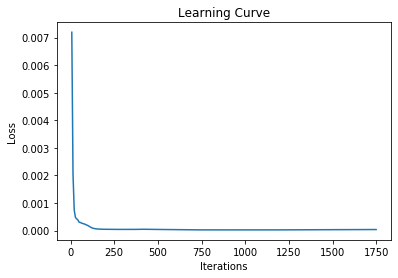

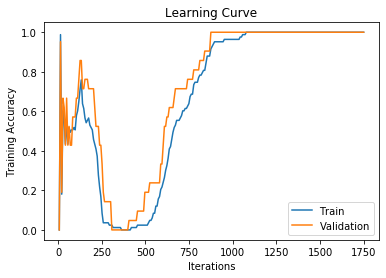

In [22]:
train_model(rnn, train_data, valid_data, train_labels, valid_labels, batch_size=12, weight_decay=0.0,
          learning_rate=0.01, num_epochs=250, checkpoint_path=None)

In [24]:
torch.save(rnn.state_dict(), '/Users/charbel/Desktop/GitHub/COVID-Hackathon/rnn_weights.pt')

In [25]:
torch.save(rnn.state_dict(), '/Users/charbel/Desktop/GitHub/COVID-Hackathon/rnn_weights.pth')

In [26]:
torch.save(rnn.state_dict(), '/Users/charbel/Desktop/GitHub/COVID-Hackathon/rnn_weights.pkl')